# Load the data

In [193]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [194]:
from sqlalchemy import create_engine


driver = 'mysql+pymysql:'
user = 'adria'
password = '00000'
ip = '35.187.114.125'
database = 'vimet'

connection_string = f'{driver}//{user}:{password}@{ip}/{database}'
engine = create_engine(connection_string)

In [195]:
orders = pd.read_sql('orders', con = engine)
items = pd.read_sql('items', con = engine)

In this notebook, we will extract all the information related to customers and load it into a specific table.

In [196]:
orders.describe()

,index,Customer,Accepts Marketing,Total,Discount Amount,Refunded Amount,Discount Code
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,969.795455,20.340909,0.840909,66.495182,1.181818,2.026136,0.168182
std,830.057141,14.425597,0.366595,43.542480,3.323314,6.155890,0.374881
min,0.000000,0.000000,0.000000,2.850000,0.000000,0.000000,0.000000
25%,117.750000,5.000000,1.000000,41.997500,0.000000,0.000000,0.000000
50%,839.500000,21.000000,1.000000,61.800000,0.000000,0.000000,0.000000
75%,1751.500000,30.000000,1.000000,79.225000,0.000000,0.000000,0.000000
max,2407.000000,53.000000,1.000000,344.450000,32.400000,45.400000,1.000000


In [197]:
orders = orders.drop(columns='index')

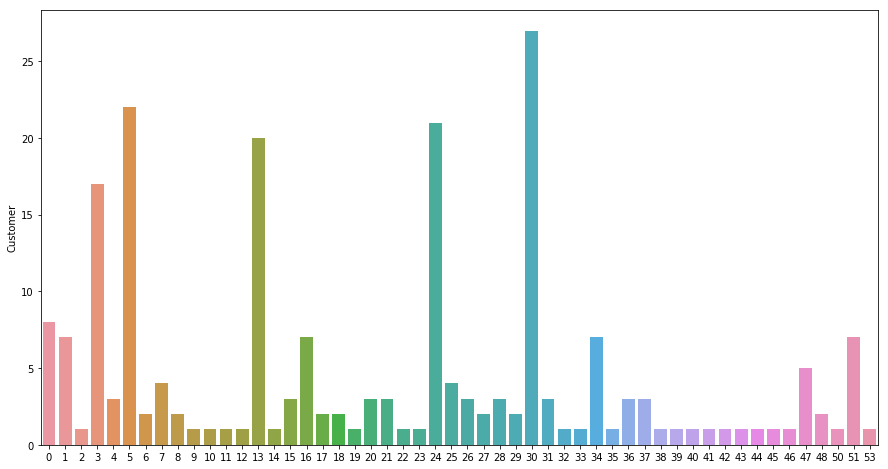

In [198]:
plt.figure(figsize=(15,8))

sns.barplot(x=orders['Customer'].value_counts().index, y=orders['Customer'].value_counts())
plt.show()

We have 53 different clients that can be classified in 3 different classes (according to the number of orders they made):
* Preferred: More than 15 orders
* Regular: From 5 to 15 orders
* Casual: 1 to 5 orders

We will add these classes to the main dataframe.

In [199]:
customers = orders['Customer'].value_counts()

In [200]:
preferred = customers[customers > 15].index
casual = customers[customers < 5].index
regular = list(set(customers.index)^set(preferred)^set(casual))

In [201]:
orders['customer_class'] = orders['Customer'].map(lambda x: 'preferred' if x in preferred else('casual' if x in casual else 'regular')) 

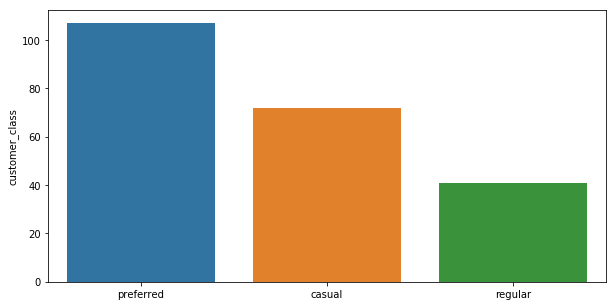

In [202]:
plt.figure(figsize=(10,5))

sns.barplot(x=orders['customer_class'].value_counts().index, y=orders['customer_class'].value_counts())
plt.show()

We can see that most of the orders are done by preferred customers while casual ones account for the second cathegory with most orders.

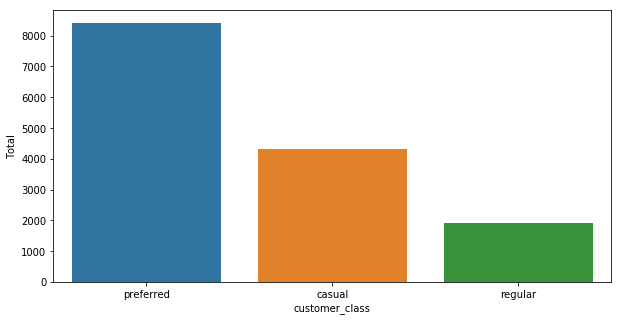

In [203]:
plt.figure(figsize=(10,5))

sns.barplot(x=orders.groupby('customer_class').sum().sort_values('Total', ascending=False)['Total'].index, y=orders.groupby('customer_class').sum().sort_values('Total', ascending=False)['Total'])
plt.show()

We observe a similar situation when looking at money spent per each customer class.

We will now check if the customers receive the order at the same place always. This would mean that shipping city and zip would be customer-specific info and not order-specific.

In [204]:
orders.groupby(['Customer','Shipping Zip']).count().head()

Name  Financial Status  Fulfillment Status  \
Customer Shipping Zip                                               
0        08029            2                 2                   2   
         Unknown          6                 6                   6   
1        08041            7                 7                   7   
2        08003            1                 1                   1   
3        08006           17                17                  17   

                       Accepts Marketing  Total  Discount Amount  \
Customer Shipping Zip                                              
0        08029                         2      2                2   
         Unknown                       6      6                6   
1        08041                         7      7                7   
2        08003                         1      1                1   
3        08006                        17     17               17   

                       Shipping Method  Shipping City  Payment Method  \
Customer Shipping Zip                                                   
0        08029                       2              2               2   
         Unknown                     6              6               6   
1        08041                       7              7               7   
2        08003                       1              1               1   
3        08006                      17             17              17   

                       Refunded Amount  Discount Code  Notes  customer_class  
Customer Shipping Zip                                                         
0        08029                       2              2      2               2  
         Unknown                     6              6      6               6  
1        08041                       7              7      7               7  
2        08003                       1              1      1               1  
3        08006                      17             17     17              17

We can see that the sipping zip can be different for one customer and different orders, so we'll keep it in orders.

In [205]:
orders.head()

,Name,Customer,Financial Status,Fulfillment Status,Accepts Marketing,Total,Discount Amount,Shipping Method,Shipping City,Shipping Zip,Payment Method,Refunded Amount,Discount Code,Notes,customer_class
0,#1247,1,paid,fulfilled,1,63.9,0.0,shargo,Barcelona,08041,Stripe,0.0,0,None,regular
1,#1246,2,paid,unfulfilled,1,94.0,0.0,gratuito,Barcelona,08003,Stripe,0.0,0,None,casual
2,#1245,3,paid,fulfilled,1,37.4,0.0,shargo,Barcelona,08006,Stripe,0.0,0,None,preferred
3,#1244,4,paid,fulfilled,1,49.9,0.0,shargo,Barcelona,08032,Stripe,0.0,0,None,casual
4,#1243,5,paid,fulfilled,1,45.0,0.0,shargo,Barcelona,08021,Stripe,0.0,0,None,preferred


In [206]:
customers = pd.DataFrame()
for order in list(orders['Customer'].unique()):
    customers = customers.append(orders[orders_raw['Customer']==order].head(1))

customers = customers[['Customer', 'Accepts Marketing', 'Shipping City', 'customer_class']]
customers = customers.reset_index(drop=True)

In [207]:
orders = orders[['Name', 'Customer', 'Financial Status', 'Fulfillment Status', 'Total', 'Discount Amount',
                'Shipping Method', 'Shipping Zip', 'Payment Method', 'Refunded Amount', 'Discount Code', 'Notes']]

# Load the data

In [208]:
orders.to_sql('orders', con = engine, if_exists='replace')
customers.to_sql('customers', con = engine, if_exists='replace')